In [2]:
# Requires an installation of Censai

import numpy as np
import matplotlib.pyplot as plt
import os, glob, re, json
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm, SymLogNorm, CenteredNorm
from censai import PowerSpectrum
from censai import PhysicalModel
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from argparse import Namespace
import math, json
import matplotlib.pylab as pylab
import h5py
from matplotlib.ticker import FuncFormatter
from astropy.visualization import ImageNormalize, LogStretch, SqrtStretch
from tqdm import tqdm
from glob import glob
from censai.definitions import COSMO, u
from astropy.constants import M_sun, G, c
from scipy.stats import linregress
from skimage.feature import peak_local_max


plt.style.use("science")
params = {'legend.fontsize': 27,
          'figure.figsize': (10, 10),
         'axes.labelsize': 27,
         'axes.titlesize': 30,#'x-large',
         'xtick.labelsize':30,
         'ytick.labelsize':30,
         'figure.titlesize': 40,
          'xtick.major.size': 8,
          'xtick.minor.size': 4,
         'xtick.major.width': 1,
          'xtick.minor.width': 1,
         'ytick.major.size': 8,
          'ytick.minor.size': 4,
         'ytick.major.width': 1,
          'ytick.minor.width': 1,

         }
pylab.rcParams.update(params)


In [3]:
# We make a slightly better definition of the Einstein radius to include only the critical mass inside the observed Einstein radius

z_lens = 0.5
z_source = 1.5
Dls = COSMO.angular_diameter_distance_z1z2(z_lens, z_source)  # value in Mpc
Ds = COSMO.angular_diameter_distance(z_source)
Dl = COSMO.angular_diameter_distance(z_lens)
sigma_crit = c ** 2 * Ds / (4 * np.pi * G * Dl * Dls)
physical_pixel_scale = 0.1 / 188 * u.Mpc

def einstein_radius(kappa, observation):
    """
    Einstein radius is computed with the mass inside the Einstein ring 
    where kappa > 1.
    Args:
        kappa: A single kappa map of shape [crop_pixels, crop_pixels, channels]
        rescaling: Possibly an array of rescaling factor of the kappa maps
        physical_pixel_scale: Pixel scale in Comoving Mpc for the kappa map grid (in Mpc/pixels, with astropy units)
        sigma_crit: Critical Density (should be in units kg / Mpc**2 with astropy units attached)
        Dds: Angular diameter distance between the deflector (d) and the source (s) (in Mpc with astropy units attached)
        Ds: Augular diameter distance between the observer and the source (in Mpc with astropy units attached)
        Dd: Augular diameter distance between the observer and the deflector (in Mpc with astropy units attached)

    Returns: Einstein radius in arcsecond (an array of floats, no astropy units attached)
    """
    # first guess
    kap = kappa
    # This is the computation used in data augmentation (also what is in definition.py)
    mass_inside_einstein_radius = np.sum(kap * (kap > 0.9)) * sigma_crit * physical_pixel_scale**2
    theta_baseline = (np.sqrt(4 * G / c ** 2 * mass_inside_einstein_radius * Dls / Ds / Dl).decompose() * u.rad).to(u.arcsec).value

    # Find the Einstein radius from the observation (defined as half the distance between two images)
    thresholds = [0.35, 0.25, 0.1, 0.05] # at 0.1 we catch all cases, but overcount a lot. So we start strict and relax our criteria to catch 2 images in most cases
    coordinates = peak_local_max(observation, min_distance=10, threshold_abs=0.4)
    if coordinates.shape[0] <= 1:
        for thresh in thresholds:
            coordinates = peak_local_max(observation, min_distance=10, threshold_abs=thresh)
            if coordinates.shape[0] > 1:
                break
    n_images = coordinates.shape[0]
    theta_x = coordinates[:, 1] * 7.69 / 128
    theta_y = coordinates[:, 0] * 7.69 / 128
    # centroid to compute the observed Einstein radius
    x0, y0 = [coordinates[:, 1].mean(), coordinates[:, 0].mean()]
    x0 *= 7.69 / 128
    y0 *= 7.69 / 128
    r = np.sqrt((theta_x - x0)**2 + (theta_y - y0)**2)
    observed_theta = r.max()

    # recenter the coordinate system on kappa center
    x = np.linspace(0, 1, kappa.shape[0]) * 7.69
    x, y = np.meshgrid(x, x)
    y0, x0 = np.unravel_index(np.argmax(kappa), [128, 128])
    x0 *= 7.69 / 128
    y0 *= 7.69 / 128
    r = np.sqrt((x - x0)**2 + (y - y0)**2)
    theta_images = np.sqrt((theta_x - x0)**2 + (theta_y - y0)**2)

    # Refine the calculation by excluding mass outside the Einstein radius
    mass_inside_einstein_radius = np.sum(kap * (r < observed_theta) * (kap > 1)) * sigma_crit * physical_pixel_scale**2
    theta_refined = (np.sqrt(4 * G / c ** 2 * mass_inside_einstein_radius * Dls / Ds / Dl).decompose() * u.rad).to(u.arcsec).value
    return theta_baseline, observed_theta, theta_refined, n_images, theta_images

In [4]:
def radial_profile(source):
    # find center
    center = np.unravel_index(np.argmax(source), source.shape)
    x0, y0 = center
    # make system of coordinates
    x, y = np.indices((source.shape))
    r = np.sqrt((x - x0)**2 + (y - y0)**2).astype(int)
    tbin = np.bincount(r.ravel(), weights=source.ravel()) # radial profile
    nr = np.bincount(r.ravel())
    profile = tbin / nr
    return profile

def radius(source, x=50): # x is the percentile of the cumulative intensity
    # find center
    center = np.unravel_index(np.argmax(source), source.shape)
    x0, y0 = center
    # make system of coordinates
    x, y = np.indices((source.shape))
    r = np.sqrt((x - x0)**2 + (y - y0)**2).astype(int)
    tbin = np.bincount(r.ravel(), weights=source.ravel()) # radial profile
    nr = np.bincount(r.ravel())
    profile = tbin / nr    
    intensity = np.cumsum(profile)
    intensity /= intensity.max()
    return np.argmin(np.abs(intensity*100 - x))

In [5]:
hf = h5py.File(os.path.join(os.getenv("CENSAI_PATH"), "results", "final_results_likelihood_ewc_optim_lr1e-6_lam4e-1.h5"), "r")
noise_rms = hf["noise_rms"][:]
chisq_ro = hf["chi_squared_reoptimized"][:]
chisq = hf["chi_squared"][:, -1] # last step of the rim
indices = np.argsort(chisq_ro)
list(hf.keys())

['chi_squared',
 'chi_squared_reoptimized',
 'chi_squared_reoptimized_series',
 'kappa',
 'kappa_coherence_spectrum',
 'kappa_coherence_spectrum_reoptimized',
 'kappa_fov',
 'kappa_frequencies',
 'kappa_optim_mse',
 'kappa_optim_mse_series',
 'kappa_pred',
 'kappa_pred_reoptimized',
 'noise_rms',
 'observation',
 'observation_coherence_spectrum',
 'observation_coherence_spectrum2',
 'observation_coherence_spectrum_reoptimized',
 'observation_fov',
 'observation_frequencies',
 'observation_pred',
 'observation_pred_reoptimized',
 'psf',
 'psf_fwhm',
 'source',
 'source_coherence_spectrum',
 'source_coherence_spectrum2',
 'source_coherence_spectrum_reoptimized',
 'source_fov',
 'source_frequencies',
 'source_optim_mse',
 'source_optim_mse_series',
 'source_pred',
 'source_pred_reoptimized']

# Compare kappa profile reconstructed slope

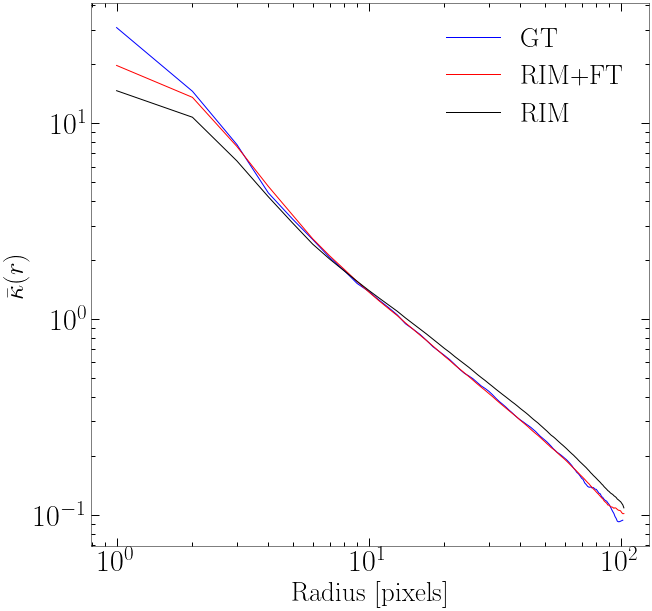

In [6]:
ell = 50 # choose an example
j = indices[ell]

kappa = hf[f"kappa"][j].squeeze()
kappa_pred = hf[f"kappa_pred_reoptimized"][j].squeeze()
kappa_pred_baseline = hf[f"kappa_pred"][j][-1].squeeze()


p = radial_profile(kappa)
r = (np.arange(p.size) + 1)
plt.loglog(r, p, "b-", label="GT")

p = radial_profile(kappa_pred)
r = (np.arange(p.size) + 1)
plt.loglog(r, p, "r-", label="RIM+FT")

p = radial_profile(kappa_pred_baseline)
r = (np.arange(p.size) + 1)
plt.loglog(r, p, "k-", label="RIM")

plt.xlabel("Radius [pixels]")
plt.ylabel(r"$\bar{\kappa}(r)$")
plt.legend()

# Einstein radius illustration

In [7]:
ell = 50 # choose an example rank ordered by chi squared of fits
j = indices[ell]
# j = 7

observation = hf[f"observation"][j].squeeze()
kappa = hf[f"kappa"][j].squeeze()

Approximate method to compute Einstein radius from kappa = 1.672

Einstein radius measured form the observation = 1.592

Refined method to compute Einstein radius from kappa = 1.581


(2, array([1.3733612 , 0.62793793]))

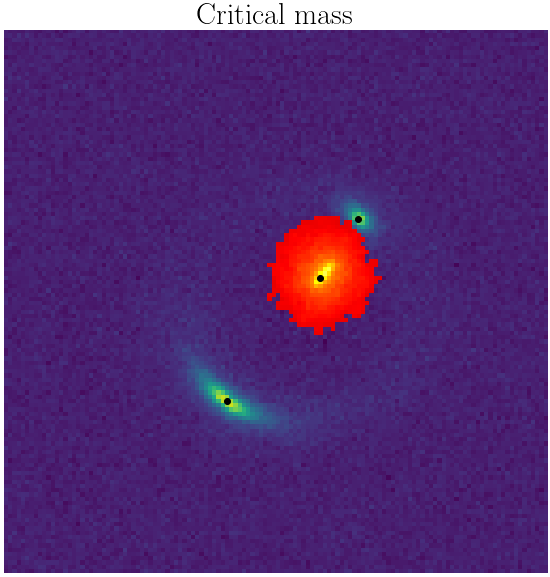

In [8]:
theta_baseline, observed_theta, theta_refined, _n_images, _theta_images = einstein_radius(kappa, observation)

# copy pasted the code for the illustration
kap = kappa
# This is the computation used in data augmentation (also what is in definition.py)
mass_inside_einstein_radius = np.sum(kap * (kap > 0.9)) * sigma_crit * physical_pixel_scale**2
theta_baseline = (np.sqrt(4 * G / c ** 2 * mass_inside_einstein_radius * Dls / Ds / Dl).decompose() * u.rad).to(u.arcsec).value

# Find the Einstein radius from the observation (defined as half the distance between two images)
thresholds = [0.35, 0.25, 0.1] # at 0.1 we catch all cases, but overcount a lot
coordinates = peak_local_max(observation, min_distance=10, threshold_abs=0.4)
if coordinates.shape[0] <= 1:
    for thresh in thresholds:
        coordinates = peak_local_max(observation, min_distance=10, threshold_abs=thresh)
        if coordinates.shape[0] > 1:
            break
x = coordinates[:, 1] * 7.69 / 128
y = coordinates[:, 0] * 7.69 / 128
# centroid to compute the observed Einstein radius
x0, y0 = [coordinates[:, 1].mean(), coordinates[:, 0].mean()]
x0 *= 7.69 / 128
y0 *= 7.69 / 128
r = np.sqrt((x - x0)**2 + (y - y0)**2)
observed_theta = r.max()

# recenter the coordinate system on kappa center
x = np.linspace(0, 1, kappa.shape[0]) * 7.69
x, y = np.meshgrid(x, x)
y0, x0 = np.unravel_index(np.argmax(kappa), [128, 128])
plt.plot(x0, y0, "ko")
x0 *= 7.69 / 128
y0 *= 7.69 / 128
r = np.sqrt((x - x0)**2 + (y - y0)**2)

# Refine the calculation by excluding mass outside the Einstein radius
mass_inside_einstein_radius = np.sum(kap * (r < observed_theta) * (kap > 1)) * sigma_crit * physical_pixel_scale**2
theta_refined = (np.sqrt(4 * G / c ** 2 * mass_inside_einstein_radius * Dls / Ds / Dl).decompose() * u.rad).to(u.arcsec).value

plt.axis("off")
plt.title("Critical mass")
plt.imshow(observation, origin="lower")
plt.imshow(kappa * (r < observed_theta) * (kappa > 1), cmap="hot", norm=LogNorm(vmin=0.1, vmax=100), origin="lower")
plt.plot(coordinates[:, 1], coordinates[:, 0], "ko")

print(f"Approximate method to compute Einstein radius from kappa = {theta_baseline:.3f}")
print()
print(f"Einstein radius measured form the observation = {observed_theta :.3f}")
print()
print(f"Refined method to compute Einstein radius from kappa = {theta_refined:.3f}")
_n_images, _theta_images / observed_theta

# Collect statistics about reconstruction like source size, kappa profile slope and Einstein radius

In [12]:
phys = PhysicalModel(pixels=128, kappa_fov=7.69, image_fov=7.69, src_fov=3, method="fft")

kappa_slope = []
kappa_pred_slope = []
kappa_ft_slope = []

kappa_local_slope = []
kappa_pred_local_slope = []
kappa_ft_local_slope = []

n_images = []
theta_images = []
rs = [] # collect distance vector from center of profile
rs_pred = []

source_radius = []
source_pred_radius = []
source_ft_radius = []
rads = [50, 60, 70, 80, 90, 93, 95, 97, 99]

theta_E = [] # einstein radius
theta_E_pred = []
theta_E_ft = []

source_flux = []
source_pred_flux = []
source_ft_flux = []

true_index = []
lams = np.arange(0.8, 1.2, 0.01)
optimal_lam = []

N = len(indices)
B = 10
# Batch the reading of compressed data as this is the computational bottleneck
for k in tqdm(range(N // B)):
    j = k * B
    observation = hf[f"observation"][j:j+B].squeeze()
    observation_pred = hf[f"observation_pred_reoptimized"][j:j+B].squeeze()
    observation_pred_prior = hf[f"observation_pred"][j:j+B].squeeze()

    source = hf[f"source"][j:j+B].squeeze()
    kappa = hf[f"kappa"][j:j+B].squeeze()
    source_pred = hf[f"source_pred_reoptimized"][j:j+B].squeeze()
    kappa_pred = hf[f"kappa_pred_reoptimized"][j:j+B].squeeze()
    kappa_pred_prior = hf[f"kappa_pred"][j:j+B, -1, ...].squeeze()
    source_pred_prior = hf[f"source_pred"][j:j+B, -1, ...].squeeze()
    for b in range(B):
        (theta0, theta_observed, theta_refined, _n_images, _theta_images) = einstein_radius(kappa[b], observation[b])
        if _n_images < 2:
            continue # validation that we have enough information in the lensed image
        
        # slope
        p = radial_profile(kappa[b])
        r = (np.linspace(0, 1, p.size) + 1/p.size) * phys.kappa_fov / theta_observed
        result = linregress(np.log(r), np.log(p)) # global slope
        if np.abs(result.rvalue) < 0.98:
            continue # remove examples with significant subclumps for this analysis
        kappa_slope.append(result.slope)
        kappa_local_slope.append(np.gradient(np.log(p), np.log(r), edge_order=2))

        p = radial_profile(kappa_pred_prior[b])
        r = (np.linspace(0, 1, p.size) + 1/p.size) * phys.kappa_fov / theta_observed
        rs.append(r)
        result = linregress(np.log(r), np.log(p))
        kappa_pred_slope.append(result.slope)
        kappa_pred_local_slope.append(np.gradient(np.log(p), np.log(r), edge_order=2))


        p = radial_profile(kappa_pred[b])
        r = (np.linspace(0, 1, p.size) + 1/p.size) * phys.kappa_fov / theta_observed
        rs_pred.append(r)
        result = linregress(np.log(r), np.log(p))
        kappa_ft_slope.append(result.slope)
        kappa_ft_local_slope.append(np.gradient(np.log(p), np.log(r), edge_order=2))

        # Einstein radius
        n_images.append(_n_images)
        theta_images.append(_theta_images / theta_observed)
        theta_E.append([theta0, theta_observed, theta_refined])
        theta_E_pred.append(einstein_radius(kappa_pred_prior[b], observation[b])[:3])
        theta_E_ft.append(einstein_radius(kappa_pred[b], observation[b])[:3])

        # source size
        I = np.cumsum(radial_profile(source[b]))
        I /= I.max()
        temp = []
        for rad in rads:
            temp.append(np.argmin(np.abs(I * 100 - rad)))
        source_radius.append(temp)

        I = np.cumsum(radial_profile(source_pred_prior[b]))
        I /= I.max()
        temp = []
        for rad in rads:
            temp.append(np.argmin(np.abs(I * 100 - rad)))
        source_pred_radius.append(temp)

        I = np.cumsum(radial_profile(source_pred[b]))
        I /= I.max()
        temp = []
        for rad in rads:
            temp.append(np.argmin(np.abs(I * 100 - rad)))
        source_ft_radius.append(temp)

        # flux
        source_flux.append(np.sum(source[b]))
        source_pred_flux.append(np.sum(source_pred_prior[b]))
        source_ft_flux.append(np.sum(source_pred[b]))

        # MST transform
        gt_profile = radial_profile(kappa[b])
        mse = []
        for lam in lams:
            new_profile = radial_profile(lam * kappa_pred[b] + (1 - lam))
            s = min(new_profile.size, gt_profile.size)
            mse.append(np.sum((new_profile[:s] - gt_profile[:s])**2 / gt_profile[:s]**2))
        optimal_lam.append(lams[np.argmin(mse)])
        
        true_index.append(j + b)


theta_E = np.stack(theta_E)
theta_E_pred = np.stack(theta_E_pred)
theta_E_ft = np.stack(theta_E_ft)

source_radius = np.stack(source_radius)
source_pred_radius = np.stack(source_pred_radius)
source_ft_radius = np.stack(source_ft_radius)

100%|██████████| 300/300 [03:28<00:00,  1.44it/s]


# Average slope of the profiles

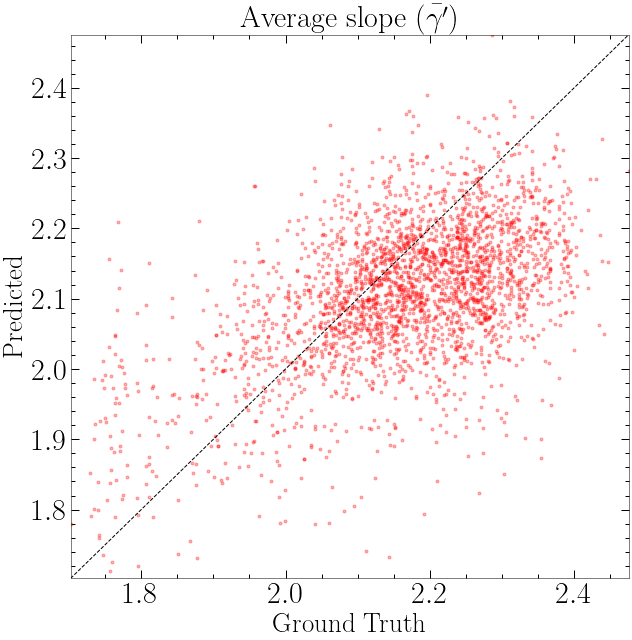

In [13]:
gamma_pred = 1 - np.array(kappa_ft_slope)
gamma_true = 1 - np.array(kappa_slope)
plt.plot(gamma_true, gamma_pred , "r.", alpha=0.3)

xmin = min(gamma_true)
xmax = max(gamma_true)

plt.ylabel("Predicted")
plt.xlabel("Ground Truth")
plt.title(r"Average slope ($\bar{\gamma'}$)")
plt.plot([xmin, xmax], [xmin, xmax], "k--")
plt.xlim(xmin, xmax)
plt.ylim(xmin, xmax);

# Local slope of the profiles 


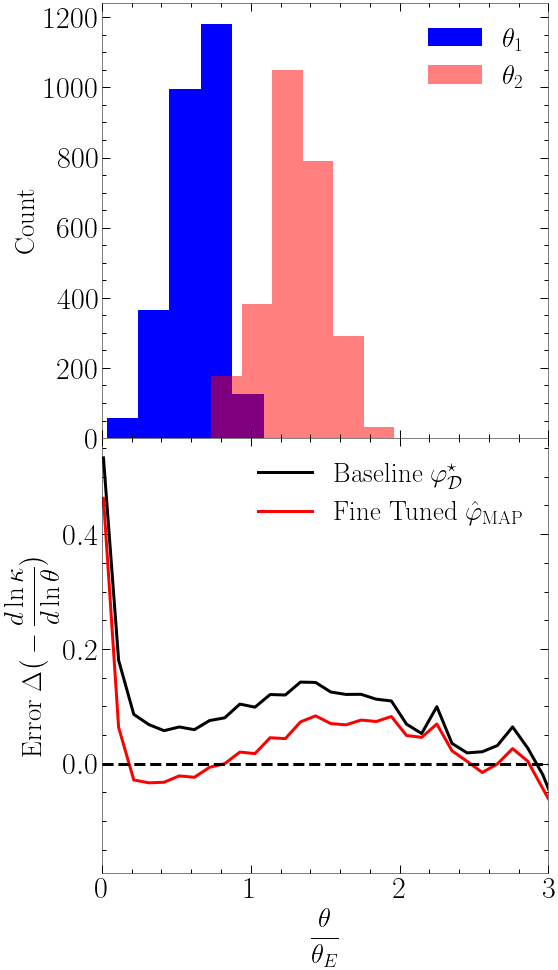

In [22]:

N = 50
distances = np.linspace(0.01, 5, N)
error_pred = np.zeros(shape=[N])
error_ft = np.zeros(shape=[N])
population_pred = np.zeros(shape=[N])
population_ft = np.zeros(shape=[N])
for i in range(len(kappa_local_slope)):

    slope_true = kappa_local_slope[i]
    slope_pred = kappa_pred_local_slope[i]
    slope_ft = kappa_ft_local_slope[i]
    # Note, the profile often truncate at the edges (large R) when it is computed off center. So we need to figure out at which distance we can compare the profiles
    size = min(slope_true.size, slope_pred.size)
    r = (np.linspace(0, 1, size) + 1/size) * phys.kappa_fov / theta_E[i, 1] # use the observed Einstein radius as normalization
    # find the distance bin we can put this statistic in
    idx = np.digitize(r, distances) - 1
    error_pred[idx] += (slope_pred[:size] - slope_true[:size])
#     error[idx] += (slope_pred[:size] - slope_true[:size]) / slope_true[:size]
    population_pred[idx] += 1
    
    size = min(slope_true.size, slope_ft.size)
    r = (np.linspace(0, 1, size) + 1/size) * phys.kappa_fov / theta_E[i, 1] # use the observed Einstein radius as normalization
    # find the distance bin we can put this statistic in
    idx = np.digitize(r, distances) - 1
    error_ft[idx] += (slope_ft[:size] - slope_true[:size])
#     error[idx] += (slope_pred[:size] - slope_true[:size]) / slope_true[:size]
    population_ft[idx] += 1
    
select_pred = population_pred > 1000 # make sure we have valid statistics
error_pred /= population_pred
select_ft = population_ft > 1000 # make sure we have valid statistics
error_ft /= population_ft

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 16), sharex=True)

theta1 = []
theta2 = []
for t in theta_images:
    theta1.append(min(t))
    theta2.append(max(t))

ax1.hist(theta1, bins=20, color="b", label=r"$\theta_1$")
ax1.hist(theta2, bins=20, color="r", alpha=0.5, label=r"$\theta_2$")
ax1.set_ylabel("Count")
ax1.legend()

ax2.plot(distances[select_pred], error_pred[select_pred], "k-", lw=3, label=r"Baseline $\varphi_{\mathcal{D}}^{\star}$")
ax2.plot(distances[select_ft], error_ft[select_ft], "r-", lw=3, label=r"Fine Tuned $\hat{\varphi}_{\mathrm{MAP}}$")

ax2.axhline(0, color="k", ls="--", lw=3)
# ax2.set_ylabel("Error on local slope")
ax2.set_ylabel(r"Error $\displaystyle \Delta \big(-\frac{d \ln \kappa}{d \ln \theta} \big)$")
ax2.set_xlabel(r"$\displaystyle \frac{\theta}{\theta_E}$")
ax2.legend()
ax2.set_xlim(0, 3)
plt.subplots_adjust(wspace=0, hspace=0);

# Einstein radius

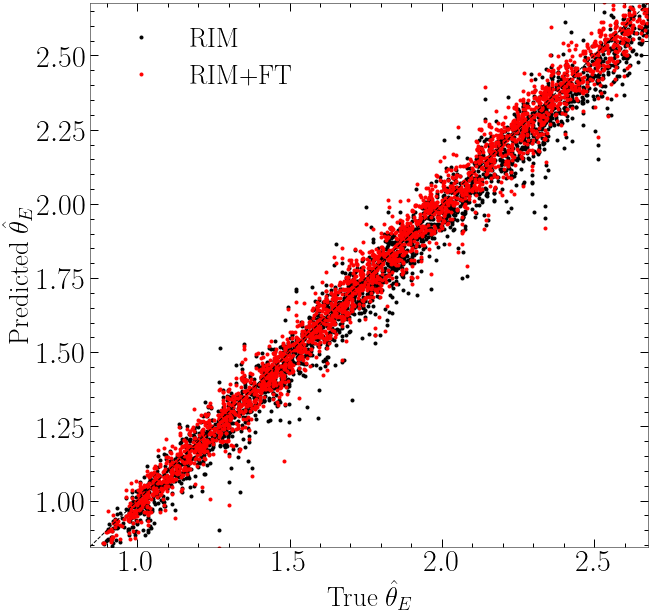

In [142]:
ell = 2 # the refined version

plt.plot(theta_E[:, ell], theta_E_pred[:, ell], "k.", label="RIM")
plt.plot(theta_E[:, ell], theta_E_ft[:, ell], "r.", label="RIM+FT")
xmin = np.min(theta_E[:, ell][theta_E[:, ell] > 0])# weird bug in the code, only a single example is at zero so its probably fine
plt.xlim(xmin, max(theta_E[:, ell]))
plt.ylim(xmin, max(theta_E[:, ell]))
plt.ylabel(r"Predicted $\hat{\theta}_E$")
plt.xlabel(r"True $\hat{\theta}_E$")
plt.legend()
plt.plot([xmin, max(theta_E[:, ell])], [xmin, max(theta_E[:, ell])], "k--")

# Source flux and size

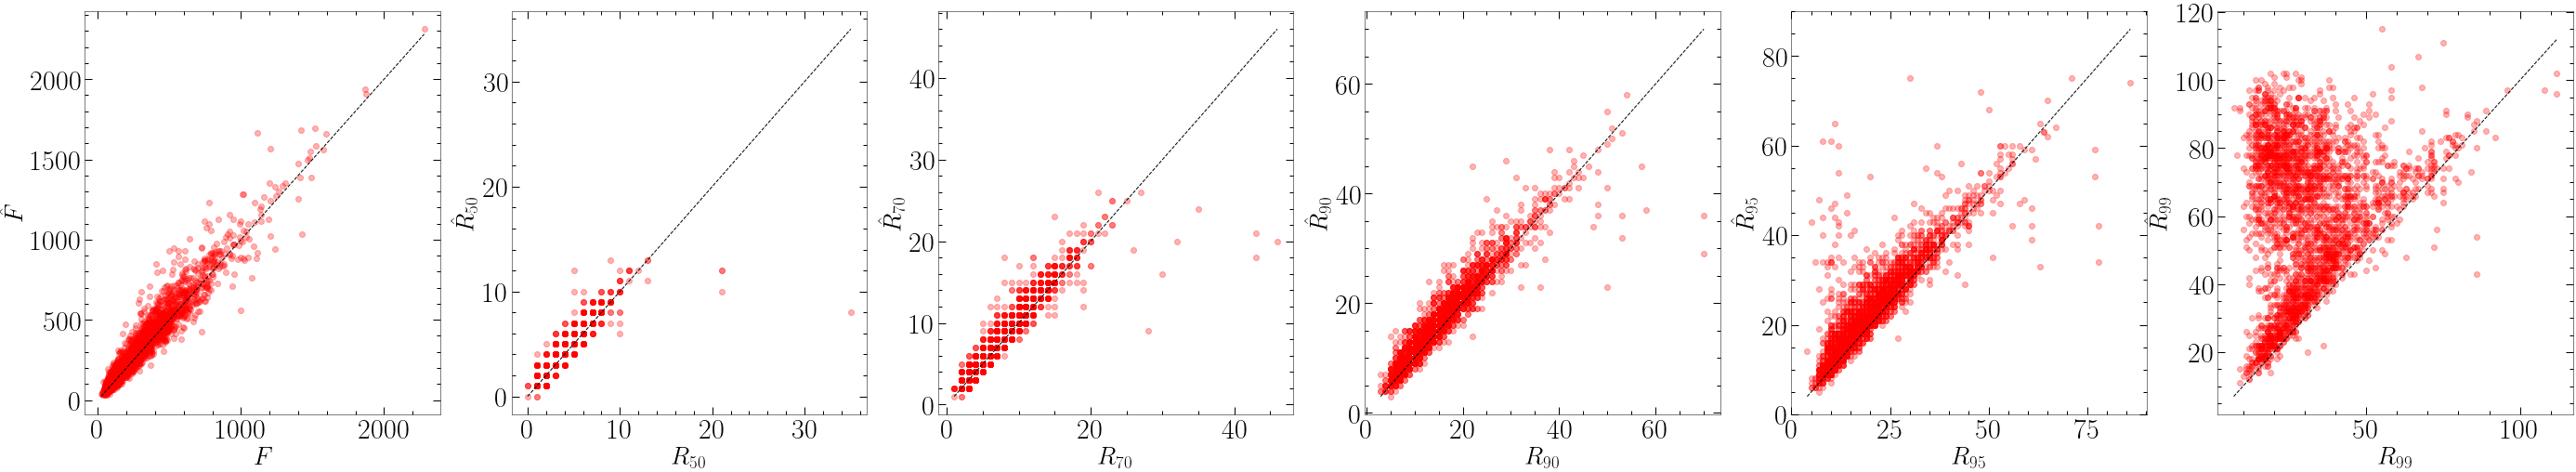

In [172]:
rads = [50, 70, 80, 90, 95, 99]
ylabels = [r"$\hat{F}$", r"$\hat{R}_{50}$", r"$\hat{R}_{70}$", r"$\hat{R}_{90}$", r"$\hat{R}_{95}$", r"$\hat{R}_{99}$"]
xlabels = [r"$F$", r"$R_{50}$", r"$R_{70}$", r"$R_{90}$", r"$R_{95}$", r"$R_{99}$"]

x_map = {0: source_flux, 1: source_radius[:, 0], 2: source_radius[:, 2], 3: source_radius[:, 4], 4: source_radius[:, 6], 5: source_radius[:, -1]}
y_map = {0: source_ft_flux, 1: source_ft_radius[:, 0], 2: source_ft_radius[:, 2], 3: source_ft_radius[:, 4], 4: source_ft_radius[:, 6], 5: source_ft_radius[:, -1]}

fig, axs = plt.subplots(1, len(ylabels), figsize=(8* len(ylabels), 8 ))

for i in range(len(ylabels)):
    x = x_map[i]
    y = y_map[i]
    xmin, xmax = min(x), max(x)
    ymin, ymax = min(y), max(y)
    axs[i].plot(x, y, "ro", alpha=0.3)
    axs[i].plot([xmin, xmax], [xmin, xmax], "k--")
    axs[i].set_ylabel(ylabels[i])
    axs[i].set_xlabel(xlabels[i])

# Mass sheet transform

# $$\kappa_\lambda \mapsto \lambda \kappa + (1 - \lambda)$$

In [159]:
ell = 50 # choose an example rank ordered by chi squared of fits
j = indices[ell]
# j = 806

observation = hf["observation"][j].squeeze()
kappa = hf["kappa"][j].squeeze()
kappa_pred = hf["kappa_pred_reoptimized"][j].squeeze()

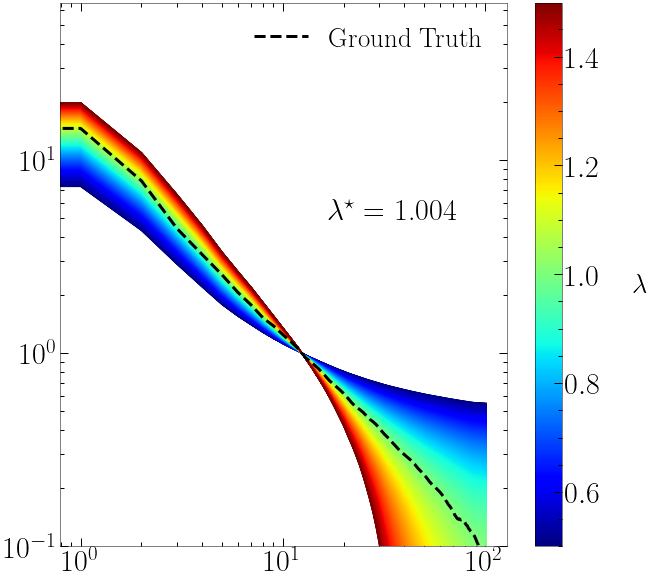

In [160]:
gt_profile = radial_profile(kappa)
mse = []
lams = np.arange(0.5, 1.5, 0.001)
_cmap = mpl.cm.get_cmap("jet")
norm = mpl.colors.Normalize(vmin=lams.min(), vmax=lams.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet)
cmap.set_array([])
for lam in lams:
    new_profile = radial_profile(lam * kappa_pred + (1 - lam))
    s = min(new_profile.size, gt_profile.size)
    mse.append(np.sum((new_profile[:s] - gt_profile[:s])**2 / gt_profile[:s]**2))
    plt.loglog(new_profile, "-", color=_cmap(norm(lam)))
plt.annotate(fr"$\lambda^\star = $ {lams[np.argmin(mse)]:.3f}", xy=(0.6, 0.6), xycoords="axes fraction", fontsize=30)
plt.loglog(gt_profile, "k--", lw=3, label="Ground Truth")
plt.ylim(1e-1)
plt.legend()
cbar = plt.colorbar(cmap)
cbar.set_label(r"$\lambda$", rotation=0, labelpad=40)

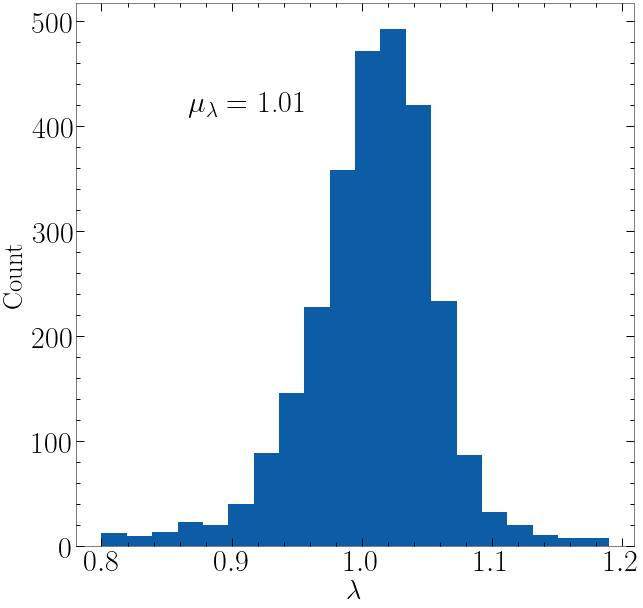

In [161]:
plt.hist(optimal_lam, bins=20);
plt.xlabel(r"$\lambda$")
plt.ylabel("Count")
plt.annotate(fr"$\mu_\lambda = $ {np.mean(optimal_lam):.2f}", xy=(0.2, 0.8), xycoords="axes fraction", fontsize=30);